### **一、將UPB資料集做成.npz檔案**
* 先運行 `convert_mat_to_csv_all.py` 將UPB資料集的.mat轉換為csv檔案
* 取工況Operating Parameter為：N09_M07_F10
* 訓練資料X的shape：(140, 250000, 3) --- 7個軸承編號，每個編號20個資料集，每個資料集包含振動訊號與2個電流訊號，資料數量為250000筆
* 利用公式算出能源效率，作為Ground Truth值

In [50]:
import pandas as pd
import numpy as np
import os

# 轉換所有訓練資料夾
folder_names = ['K002', 'KA01', 'KA05', 'KA07', 'KI01', 'KI05', 'KI07']
operating_parameter = 'N09_M07_F10'  # 指定工況
folder_indexes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

# 定義空的y
y_data_array = np.zeros((140, 1))
data_index = 0

for folder_name in folder_names:
    for folder_index in folder_indexes:
        current_vib_csv_file_path = os.path.join(folder_name, f'{operating_parameter}_{folder_name}_{folder_index}', 
                                     f'{operating_parameter}_{folder_name}_{folder_index}_current_vib.csv')
        # print(csv_file_path)
        df = pd.read_csv(current_vib_csv_file_path)

        # 轉換為numpy數組
        X_data_array = df.to_numpy()

        # 減去後面幾個row以達到250000筆
        n_keep = 250000
        X_data_array = X_data_array[:n_keep]  # (250000, 3)
        # print(X_data_array.shape)

        # 變為3維陣列以方便堆疊
        X_data_array = np.expand_dims(X_data_array, axis=0)  # (1, 250000, 3)
        # print(X_data_array.shape)

        # 堆疊成為大陣列
        if data_index == 0:
            X_data_array_stack = np.copy(X_data_array)

        else:
            X_data_array_stack = np.concatenate((X_data_array_stack, X_data_array), axis=0)

        # print("X_data_array_stack.shape: ", X_data_array_stack.shape)

        # 製作y:
        ME_para_csv_file_path = os.path.join(folder_name, f'{operating_parameter}_{folder_name}_{folder_index}', 
                                     f'{operating_parameter}_{folder_name}_{folder_index}_ME_parameter.csv')
        
        df = pd.read_csv(ME_para_csv_file_path)

        # 轉換為numpy數組
        df = df.to_numpy()  # (16002, 3)

        # 減去後面幾個row以達到16000筆
        n_keep = 16000
        df = df[:n_keep]  # (16000, 3)

        # 計算平均輸出功率
        p_out_array = np.zeros((16000, 1))
        for i in range(len(p_out_array)):
            p_out_array[i] = df[i, 1]*2*3.14159265358/60 * df[i, 2]

        p_out = np.mean(p_out_array)

        # 計算平均輸入功率
        p_in_array = np.zeros((250000, 1))
        for i in range(len(p_in_array)):
            p_in_array[i] = (abs(X_data_array_stack[data_index, i, 0]) + abs(X_data_array_stack[data_index, i, 1])) * 400 * 0.9  # 輸入功率 = 電流 x 電壓 x Power Factor(假設0.9)

        p_in = np.mean(p_in_array)

        # 計算效率
        efficiency = (p_out / p_in - 0.105) * 10000  # 扣除自訂的基本值再乘以10000，使數據範圍在大約-10~10之間
        y_data_array[data_index] = efficiency
        # print(efficiency)

        print("data_index {} processed.".format(data_index))

        data_index += 1

# 使用 savez_compressed 函數壓縮儲存到一個檔案，並為每個陣列指定一個key
npz_file_path = 'UPB_ME_parameter_N09_M07_F10_data.npz'
np.savez_compressed(npz_file_path, X=X_data_array_stack, y=y_data_array)

data_index 0 processed.
data_index 1 processed.
data_index 2 processed.
data_index 3 processed.
data_index 4 processed.
data_index 5 processed.
data_index 6 processed.
data_index 7 processed.
data_index 8 processed.
data_index 9 processed.
data_index 10 processed.
data_index 11 processed.
data_index 12 processed.
data_index 13 processed.
data_index 14 processed.
data_index 15 processed.
data_index 16 processed.
data_index 17 processed.
data_index 18 processed.
data_index 19 processed.
data_index 20 processed.
data_index 21 processed.
data_index 22 processed.
data_index 23 processed.
data_index 24 processed.
data_index 25 processed.
data_index 26 processed.
data_index 27 processed.
data_index 28 processed.
data_index 29 processed.
data_index 30 processed.
data_index 31 processed.
data_index 32 processed.
data_index 33 processed.
data_index 34 processed.
data_index 35 processed.
data_index 36 processed.
data_index 37 processed.
data_index 38 processed.
data_index 39 processed.
data_index

In [51]:
# 測試載入壓縮檔案
data = np.load('UPB_ME_parameter_N09_M07_F10_data.npz')

# 透過指定的key來存取陣列
arr1_loaded = data['X']
arr2_loaded = data['y']

print(arr1_loaded.shape)
print(arr2_loaded.shape)

(140, 250000, 3)
(140, 1)


### **二、讀取UPB的.npz檔案並做資料預處理**

##### **1. 導入必要的程式庫**

In [2]:
from tqdm import tqdm, trange
import numpy as np

##### **2. 資料的預處理(二選一)**

****選擇一：預測能效****

In [71]:
# 讀取UPB的.npz檔案
data_input_file = 'UPB_ME_parameter_N09_M07_F10_data.npz'
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X'][:, 125000:156250, :]  # (140, 31250, 3) 只取訊號的0.5s區域
y = tmp['y']  # (140, 1)

# 將陣列中的資料順序做洗牌
indices = np.random.permutation(X.shape[0])  # 生成一個隨機的索引序列

# 使用這個索引序列來重新安排 X 和 y
X_shuffled = X[indices]
y_shuffled = y[indices]

# print(X_shuffled.shape)  # (140, 31250, 3)
# print(y_shuffled.shape)  # (140, 1)

#===============================減少數據數量的方式===================================

# 方法一：使用切片進行降採樣：在第二維每隔10個點取一個點
# X_shuffled = X_shuffled[:, ::10, :]  # (140, 25000, 3)

# 方法二：使用RMS來減少數據長度：在第二維每隔5個點取RMS
# X_shuffled_rms = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存RMS計算後的數據

# for i in trange(140, desc='RMS Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個特徵
#         # 對於每個特徵，將數據分組，每10筆數據一組，並計算每組的RMS
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算RMS並賦值
#             X_shuffled_rms[i, k, j] = np.sqrt(np.mean(np.square(group)))

# X_shuffled = np.copy(X_shuffled_rms)

# 方法三：使用Mean來減少數據長度：在第二維每隔5個點取Mean
# X_shuffled_mean = np.zeros((140, 50000))  # 初始化一個空陣列來儲存平均值計算後的數據

# for i in trange(140, desc='Mean Processing'):  # 遍歷每個數據集
#     # 對於每個軸，將數據分組，每10筆數據一組，並計算每組的平均值
#     for k in range(50000):  # 遍歷每組數據
#         # 提取當前組的數據
#         group = X_shuffled[i, k*5:(k+1)*5]
#         # 計算平均值並賦值
#         X_shuffled_mean[i, k] = np.mean(group)

# X_shuffled = np.copy(X_shuffled_mean)

# 方法四：使用FFT轉換
# X_shuffled_fft = np.zeros((140, 250000, 3), dtype=np.complex)  # 初始化一個空陣列來儲存FFT結果，注意FFT結果的大小與原數據相同

# for i in trange(140, desc='FFT Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對每個軸的數據進行FFT轉換
#         X_shuffled_fft[i, :, j] = np.fft.fft(X_shuffled[i, :, j])

# X_shuffled = np.copy(np.abs(X_shuffled_fft))  # 幅度

#===================================================================================

print(X_shuffled.shape)  # (140, 31250, 3)

# 拆解成訓練集與驗證集
X_shuffled_val = np.copy(X_shuffled[120:])  # (20, 31250, 3)
y_shuffled_val = np.copy(y_shuffled[120:])  # (20, 1)
X_shuffled = X_shuffled[:120]  # (120, 31250, 3)
y_shuffled = y_shuffled[:120]  # (120, 1)

# 降低y維度至一維
y_shuffled = np.squeeze(y_shuffled, axis=1)  # (120,)
X_shuffled_ = X_shuffled.reshape(120, -1)  # 將 X 轉換為形狀為 (120, 93750) 的2D數組
X_shuffled_val_ = X_shuffled_val.reshape(20, -1)  # (20, 93750)

print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

# 原作者： X_train_(18384, 100, 3, 1), y_train_one_hot(18384, 6)
# X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 25000, 1)
# X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 25000, 1)
# print(X_shuffled_.shape)

(140, 31250, 3)
X_shuffled_val:(20, 31250, 3), y_shuffled_val:(20, 1), X_shuffled:(120, 31250, 3), y_shuffled:(120,)


****選擇二：預測3種類別`Healthy`、`Outer ring damage`、`Inner ring damage`****

In [33]:
# 讀取UPB的.npz檔案
data_input_file = 'UPB_current_vib_N09_M07_F10_data.npz'
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']  # (140, 250000, 3)
y_one_hot = tmp['y']  # (140, 3)

# 將陣列中的資料順序做洗牌
indices = np.random.permutation(X.shape[0])  # 生成一個隨機的索引序列

# 使用這個索引序列來重新安排 X 和 y
X_shuffled = X[indices]
y_shuffled = y_one_hot[indices]

# print(X_shuffled.shape)  # (140, 250000, 3)
# print(y_shuffled.shape)  # (140, 3)

#===============================減少數據數量的方式===================================

# 方法一：使用切片進行降採樣：在第二維每隔10個點取一個點
# X_shuffled = X_shuffled[:, ::10, :]  # (140, 25000, 3)

# 方法二：使用RMS來減少數據長度：在第二維每隔5個點取RMS
# X_shuffled_rms = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存RMS計算後的數據

# for i in trange(140, desc='RMS Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個特徵
#         # 對於每個特徵，將數據分組，每10筆數據一組，並計算每組的RMS
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算RMS並賦值
#             X_shuffled_rms[i, k, j] = np.sqrt(np.mean(np.square(group)))

# X_shuffled = np.copy(X_shuffled_rms)

# 方法三：使用Mean來減少數據長度：在第二維每隔10個點取Mean
# X_shuffled_mean = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存平均值計算後的數據

# for i in trange(140, desc='Mean Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對於每個軸，將數據分組，每10筆數據一組，並計算每組的平均值
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算平均值並賦值
#             X_shuffled_mean[i, k, j] = np.mean(group)

# X_shuffled = np.copy(X_shuffled_mean)

# 方法四：使用FFT轉換
# X_shuffled_fft = np.zeros((140, 250000, 3), dtype=np.complex)  # 初始化一個空陣列來儲存FFT結果，注意FFT結果的大小與原數據相同

# for i in trange(140, desc='FFT Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對每個軸的數據進行FFT轉換
#         X_shuffled_fft[i, :, j] = np.fft.fft(X_shuffled[i, :, j])

# X_shuffled = np.copy(np.abs(X_shuffled_fft))  # 幅度

# 方法五：採用0.25s的數據
X_shuffled = X_shuffled[:, 125000:140625, :]  # (140, 15625, 3)

# 方法六：只採用振動數據
X_shuffled = X_shuffled[:, :, 2]

#===================================================================================

print(X_shuffled.shape)  # (140, 15625)

# 拆解成訓練集與驗證集
X_shuffled_val = np.copy(X_shuffled[120:])  # (20, 15625)
y_shuffled_val = np.copy(y_shuffled[120:])  # (20, 3)
X_shuffled = X_shuffled[:120]  # (120, 15625)
y_shuffled = y_shuffled[:120]  # (120, 3)
print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

y = np.argmax(y_shuffled, axis=1)
y_val = np.argmax(y_shuffled_val, axis=1)

# 增加維度
# X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 15625, 1)
# X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 15625, 1)
# print(X_shuffled_.shape)

(140, 15625)
X_shuffled_val:(20, 15625), y_shuffled_val:(20, 3), X_shuffled:(120, 15625), y_shuffled:(120, 3)


##### **3. 模型的輸入資料可視化**

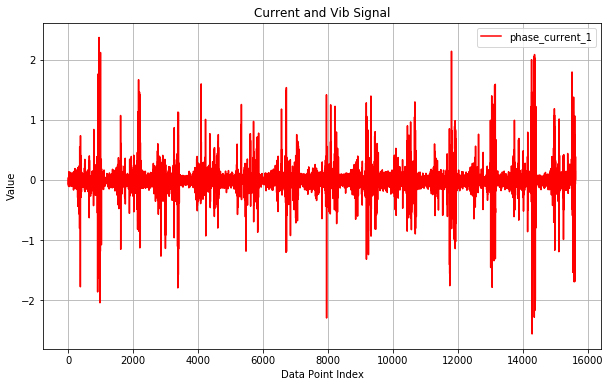

In [28]:
# 繪製資料分布
import matplotlib.pyplot as plt

# Select the first dataset for simplicity
dataset_index = 71  # 選擇隨機排列後的第幾筆資料
dataset = X_shuffled[dataset_index, :, :]

# Separate the data by axis
x_axis_data = dataset[:, 0]  # phase_current_1 data
y_axis_data = dataset[:, 1]  # phase_current_2 data
z_axis_data = dataset[:, 2]  # vibration_1 data

# Create a smooth line chart for the 3-axis data
plt.figure(figsize=(10, 6))
plt.plot(x_axis_data, color='r', label='phase_current_1')
plt.plot(y_axis_data, color='g', label='phase_current_2')
plt.plot(z_axis_data, color='b', label='vibration_1')
plt.title('Current and Vib Signal')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### **三、訓練模型**

##### **1. 導入必要的程式庫**

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

##### **2. 定義與訓練模型(二選一)**

****選擇一：預測能效****

In [ ]:
# 創建隨機森林回歸模型
random_forest_regressor = RandomForestRegressor(
    n_estimators=1500,          # 增加樹的數量
    # max_features='sqrt',       # 考慮的特徵數量
    max_depth=None,            # 允許樹成長到最大深度
    min_samples_split=20,      # 分割內部節點所需的最小樣本數
    min_samples_leaf=8,        # 葉節點所需的最小樣本數
    random_state=42,            # 確保結果的可重現性
    verbose=5
)

# 訓練模型
random_forest_regressor.fit(X_shuffled_, y_shuffled)

# 使用模型進行預測
y_pred = random_forest_regressor.predict(X_shuffled_val_)

# 計算模型的均方誤差（MSE）作為性能評估
mse = mean_squared_error(y_shuffled_val, y_pred)
print(f'Model Mean Squared Error: {mse}')

In [ ]:
# 在驗證集上驗證準確率
for i in range(len(y_shuffled_val)):
    print("Ground Truth: {}, Predict: {}".format(y_shuffled_val[i], y_pred[i]))

****選擇二：預測3種類別`Healthy`、`Outer ring damage`、`Inner ring damage`****

In [42]:
# 創建隨機森林分類器實例
rf_classifier = RandomForestClassifier(
    n_estimators=5000, 
    max_features='sqrt',       # 考慮的特徵數量
    random_state=42,
    max_depth=30000,
    min_samples_split=2,      # 分割內部節點所需的最小樣本數
    min_samples_leaf=2,        # 葉節點所需的最小樣本數
    verbose=5
)

# 訓練模型
rf_classifier.fit(X_shuffled, y)

# 進行預測
predictions = rf_classifier.predict(X_shuffled_val)

# 評估模型
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Accuracy: 0.5


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    0.4s finished
